In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pycaret
from pycaret.classification import *

In [3]:
train = pd.read_csv('train.csv')
train

,DATETIMEDATA,PM25,PM10,O3,CO,NO2,SO2,WS,TEMP,RH,WD
0,2024-01-01 00:00:00,11.5,20.0,23.00,0.20,1.00,0.00,2,28.0,86,15
1,2024-01-01 01:00:00,11.2,18.0,22.00,0.27,2.00,0.00,2,27.0,88,352
2,2024-01-01 02:00:00,9.8,17.0,19.00,0.26,3.00,0.00,2,27.0,90,348
3,2024-01-01 03:00:00,9.7,17.0,17.00,0.26,2.00,0.00,2,26.0,91,1
4,2024-01-01 04:00:00,8.7,16.0,17.00,0.26,2.00,0.00,2,27.0,90,3
...,...,...,...,...,...,...,...,...,...,...,...
1138,2024-02-18 06:00:00,15.6,32.0,14.00,0.05,3.00,0.00,1,25.0,85,30
1139,2024-02-18 07:00:00,17.7,37.0,7.00,0.07,2.29,0.00,0,25.0,84,274
1140,2024-02-18 08:00:00,21.4,48.0,18.00,0.20,2.00,0.14,2,29.0,64,56
1141,2024-02-18 09:00:00,16.3,41.0,22.88,0.16,1.00,0.00,4,31.0,57,60


In [4]:
test = pd.read_csv('test.csv')
test

,DATETIMEDATA,PM25,PM10,O3,CO,NO2,SO2,WS,TEMP,RH,WD
0,2024-02-18 11:00:00,15.9,32.0,24.0,0.13,1.0,0.0,5,33.0,53,48
1,2024-02-18 12:00:00,12.6,33.0,27.0,0.14,1.0,0.0,5,33.0,51,49
2,2024-02-18 13:00:00,10.1,39.0,27.0,0.13,1.0,0.0,4,34.0,50,49
3,2024-02-18 14:00:00,8.7,34.0,28.0,0.13,1.0,0.0,5,33.0,51,52
4,2024-02-18 15:00:00,12.1,32.0,23.0,0.14,1.0,0.0,6,33.0,55,56
...,...,...,...,...,...,...,...,...,...,...,...
486,2024-03-09 17:00:00,8.6,25.0,20.0,0.08,1.0,0.0,4,31.0,62,61
487,2024-03-09 18:00:00,7.4,23.0,16.0,0.09,2.0,0.0,3,30.0,68,47
488,2024-03-09 19:00:00,6.5,22.0,13.0,0.11,3.0,0.0,2,29.0,73,39
489,2024-03-09 20:00:00,6.6,22.0,12.0,0.12,3.0,0.0,2,28.0,77,32


In [5]:
from pycaret.regression import *
train['DATETIMEDATA'] = pd.to_datetime(train['DATETIMEDATA'])
train = train.drop(columns=['TEMP','RH','WD','SO2'])

In [6]:
regression_setup = setup(train, target='PM25', session_id=123, date_features=['DATETIMEDATA'], normalize=True)
best = compare_models()
et_model = create_model('et')

,Description,Value
0,Session id,123
1,Target,PM25
2,Target type,Regression
3,Original data shape,"(1143, 7)"
4,Transformed data shape,"(1143, 9)"
5,Transformed train set shape,"(800, 9)"
6,Transformed test set shape,"(343, 9)"
7,Numeric features,5
8,Date features,1
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,1.6845,7.0313,2.6263,0.8634,0.1500,0.1082,0.0290
rf,Random Forest Regressor,1.7321,7.1818,2.6562,0.8601,0.1523,0.1122,0.0310
gbr,Gradient Boosting Regressor,1.7822,7.3400,2.6841,0.8571,0.1533,0.1157,0.0160
lightgbm,Light Gradient Boosting Machine,1.8275,7.8837,2.7880,0.8469,0.1529,0.1135,0.0530
knn,K Neighbors Regressor,2.1537,9.7276,3.0918,0.8117,0.1716,0.1370,0.0080
ada,AdaBoost Regressor,2.6406,11.0967,3.3137,0.7824,0.1899,0.1718,0.0130
dt,Decision Tree Regressor,2.3394,13.1779,3.5938,0.7423,0.2018,0.1497,0.0060
br,Bayesian Ridge,2.4815,13.1236,3.6016,0.7381,0.1982,0.1592,0.0060
ridge,Ridge Regression,2.4791,13.1240,3.6016,0.7380,0.1982,0.1590,0.0060
lar,Least Angle Regression,2.4773,13.1250,3.6017,0.7380,0.1982,0.1589,0.0070


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.6079,6.2371,2.4974,0.8814,0.1506,0.1015
1,1.5228,4.6069,2.1464,0.8887,0.1268,0.1002
2,2.0127,10.1234,3.1817,0.7907,0.1752,0.1226
3,1.5096,4.5630,2.1361,0.8938,0.1306,0.1012
4,1.6834,7.5759,2.7524,0.8479,0.1589,0.1134
5,2.0929,8.9356,2.9892,0.8516,0.1609,0.1318
6,1.7507,8.0884,2.8440,0.8457,0.1470,0.1037
7,1.5513,6.3055,2.5111,0.8780,0.1400,0.0994
8,1.6904,9.0662,3.0110,0.8541,0.1678,0.1070


In [7]:
tuned_et_model = tune_model(et_model)
bagged_model = ensemble_model(tuned_et_model, n_estimators=20)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.8179,6.4558,2.5408,0.8772,0.1569,0.1234
1,2.0322,6.9342,2.6333,0.8325,0.1614,0.1382
2,2.0582,10.2070,3.1948,0.7890,0.1791,0.1330
3,1.7353,6.5132,2.5521,0.8485,0.1551,0.1241
4,1.9086,8.7010,2.9497,0.8253,0.1797,0.1376
5,2.5506,14.7900,3.8458,0.7543,0.1909,0.1634
6,1.8810,8.2374,2.8701,0.8429,0.1453,0.1116
7,1.9217,10.0952,3.1773,0.8046,0.1671,0.1219
8,2.0117,10.4294,3.2295,0.8322,0.1798,0.1279


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5893,5.8259,2.4137,0.8892,0.1447,0.1030
1,1.6815,5.1656,2.2728,0.8752,0.1337,0.1110
2,1.9290,9.1522,3.0253,0.8108,0.1663,0.1185
3,1.5049,4.7323,2.1754,0.8899,0.1338,0.1045
4,1.6675,7.4306,2.7259,0.8508,0.1613,0.1141
5,2.1069,9.4470,3.0736,0.8431,0.1602,0.1318
6,1.7231,7.7905,2.7911,0.8514,0.1438,0.1022
7,1.5200,6.1469,2.4793,0.8810,0.1400,0.0984
8,1.6393,8.9380,2.9896,0.8562,0.1651,0.1019


In [8]:
now = pd.Timestamp.now()
start_date = now.date()
end_date = start_date + pd.DateOffset(days=7)
future_dates = pd.date_range(start=start_date, end=end_date, freq='D')

In [9]:
future_data = pd.DataFrame({'DATETIMEDATA': future_dates})
future_data['PM10'] = train['PM10'].mean().round(2)
future_data['O3'] = train['O3'].mean().round(2)
future_data['CO'] = train['CO'].mean().round(2)
future_data['NO2'] = train['NO2'].mean().round(2)
future_data['WS'] = train['WS'].mean().round(2)

In [10]:
predictions = predict_model(bagged_model, data=future_data)
mpdf = pd.DataFrame(predictions, columns=['DATETIMEDATA', 'prediction_label'])
mpdf["prediction_label"] = mpdf["prediction_label"].round(2)
mpdf

,DATETIMEDATA,prediction_label
0,2024-03-11,18.33
1,2024-03-12,18.25
2,2024-03-13,17.89
3,2024-03-14,17.42
4,2024-03-15,16.80
5,2024-03-16,17.31
6,2024-03-17,17.32
7,2024-03-18,17.51


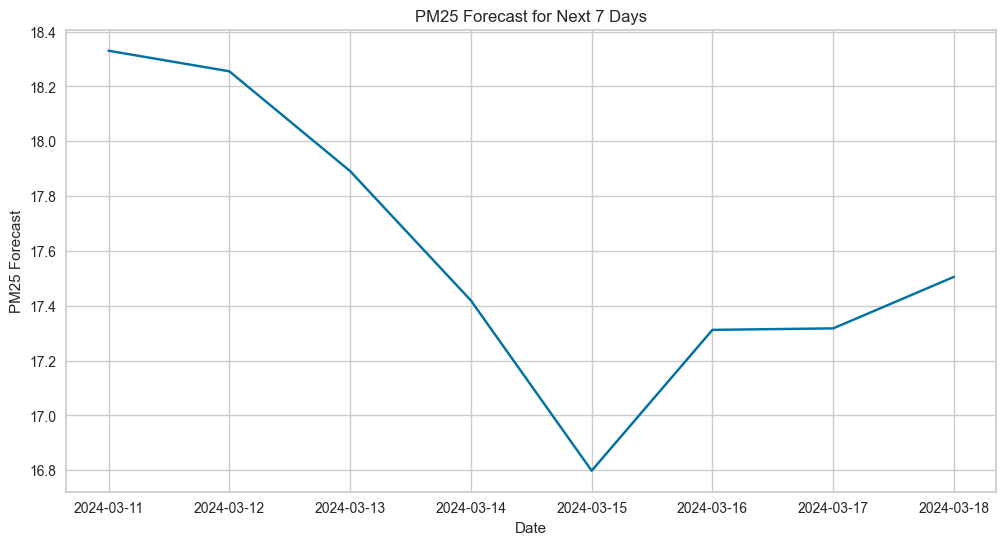

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(future_dates, predictions['prediction_label'])
plt.xlabel('Date')
plt.ylabel('PM25 Forecast')
plt.title('PM25 Forecast for Next 7 Days')
plt.grid(True)
plt.show()

In [12]:
save_model(bagged_model, 'PM25_pipeline')
load_model('PM25_pipeline')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=FastMemory(location=C:\Users\student\AppData\Local\Temp\joblib),
         steps=[('date_feature_extractor',
                 TransformerWrapper(include=['DATETIMEDATA'],
                                    transformer=ExtractDateTimeFeatures())),
                ('numerical_imputer',
                 TransformerWrapper(include=['PM10', 'O3', 'CO', 'NO2', 'WS'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('normalize', TransformerWrapper(transformer=StandardScaler())),
                ('trained_model',
                 BaggingRegressor(estimator=ExtraTreesRegressor(n_jobs=-1,
                                                                random_state=123),
                                  n_estimators=20, random_state=123))])

In [13]:
mean_value = pd.read_csv('mean_value.csv')
PM25_mean = mean_value.drop(columns=['PM10','O3','CO','NO2','SO2','WS','TEMP','RH','WD'])
PM25_mean

,Date,PM25
0,2024-01-01,11.55
1,2024-01-02,11.47
2,2024-01-03,11.34
3,2024-01-04,13.06
4,2024-01-05,24.92
...,...,...
64,2024-03-05,16.46
65,2024-03-06,23.10
66,2024-03-07,23.24
67,2024-03-08,23.41
